In [44]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib notebook

In [2]:
#real[-3.09,2.81], real[-2.39,3.19]
data = np.genfromtxt('banana.dat', dtype=np.float64, delimiter=",")
X,y = data[:,:-1], data[:,-1]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
neighbors = [10, 25, 50]
folds = [2, 5, 10]

In [10]:
def kNN(x, y, n, k):
    weights = 'uniform'
    knnModels = [KNeighborsClassifier(n_neighbors=i, weights=weights) for i in n]
    eOut = []
    kf = KFold(n_splits=k)
    for knn in knnModels:
        mEOut = []
        for trainIndex, testIndex in kf.split(x):
            xVTrain, yVTrain = x[trainIndex], y[trainIndex]
            xVTest, yVTest = x[testIndex], y[testIndex]
            score = knn.fit(xVTrain, yVTrain).score(xVTest, yVTest)
            mEOut.append(1-score)
        eOut.append(np.mean(mEOut))
    return knnModels, eOut, [1-e for e in eOut]

def dKNN(x, y, n, k):
    weights = 'distance'
    knnModels = [KNeighborsClassifier(n_neighbors=i, weights=weights) for i in n]
    eOut = []
    kf = KFold(n_splits=k)
    for knn in knnModels:
        mEOut = []
        for trainIndex, testIndex in kf.split(x):
            xVTrain, yVTrain = x[trainIndex], y[trainIndex]
            xVTest, yVTest = x[testIndex], y[testIndex]
            score = knn.fit(xVTrain, yVTrain).score(xVTest, yVTest)
            mEOut.append(1-score)
        eOut.append(np.mean(mEOut))
    return knnModels, eOut, [1-e for e in eOut]

def gaussianWeight(distancesArray):
    weightsArray = []
    for distances in distancesArray:
        mean = np.mean(distances)
        sd = np.std(distances)
        weights = []
        for d in distances:
            if d <= mean:
                weights.append(1/2)
            elif d < mean + sd:
                weights.append(1/4)
            elif d < mean + 2*sd:
                weights.append(1/8)
            elif d < mean + 3*sd:
                weights.append(1/16)
            else:
                weights.append(1/32)
        weightsArray.append(weights)
    return weightsArray

def gKNN(x, y, n, k):
    weights = gaussianWeight
    knnModels = [KNeighborsClassifier(n_neighbors=i, weights=weights) for i in n]
    eOut = []
    kf = KFold(n_splits=k)
    for knn in knnModels:
        mEOut = []
        for trainIndex, testIndex in kf.split(x):
            xVTrain, yVTrain = x[trainIndex], y[trainIndex]
            xVTest, yVTest = x[testIndex], y[testIndex]
            score = knn.fit(xVTrain, yVTrain).score(xVTest, yVTest)
            mEOut.append(1-score)
        eOut.append(np.mean(mEOut))
    return knnModels, eOut, [1-e for e in eOut]

In [77]:
results = {2:[], 5:[], 10:[]}
foldsBar = tqdm(folds, total=100, ascii=True)
for k in foldsBar:
    foldsBar.set_description("Processing kNN with uniform distance for %i-fold" % k)
    kModel, kEout, kScore = kNN(xTrain, yTrain, neighbors, k)
    foldsBar.update(100/6)
    foldsBar.set_description("Processing kNN with gaussian distance for %i-fold" % k)
    gModel, gEout, gScore = gKNN(xTrain, yTrain, neighbors, k)
    foldsBar.update(100/6)
    foldsBar.set_description("Processing kNN with inverse distance for %i-fold" % k)
    dModel, dEout, dScore = dKNN(xTrain, yTrain, neighbors, k)
    foldsBar.update(100/6)
    kFoldResults = {'knn':[kModel, kEout, kScore], 'gknn':[gModel, gEout, gScore], 
                   'dknn':[dModel, dEout, dScore]}
    results[k] = kFoldResults
foldsBar.close()

Processing kNN with inverse distance for 10-fold:   3%|3         | 3/100 [00:03<01:41,  1.05s/it]                  


In [111]:
r2 = [(int(i* 10**5) / 10.0**5) for i in results[2]['knn'][1]]
r5 = [(int(i* 10**5) / 10.0**5) for i in results[5]['knn'][1]]
r10 = [(int(i* 10**5) / 10.0**5) for i in results[10]['knn'][1]]
print(r2)
print(r5)
print(r10)
print("best val error: ", np.min(r2+r5+r10))

[0.10141, 0.09504, 0.09905]
[0.10094, 0.09669, 0.09669]
[0.09929, 0.09858, 0.0974]
best val error:  0.09504


In [113]:
gH = results[2]['knn'][0][1]
gH.score(xTest, yTest)

0.9037735849056604

### Plot kNN with uniform weights

<IPython.core.display.Javascript object>


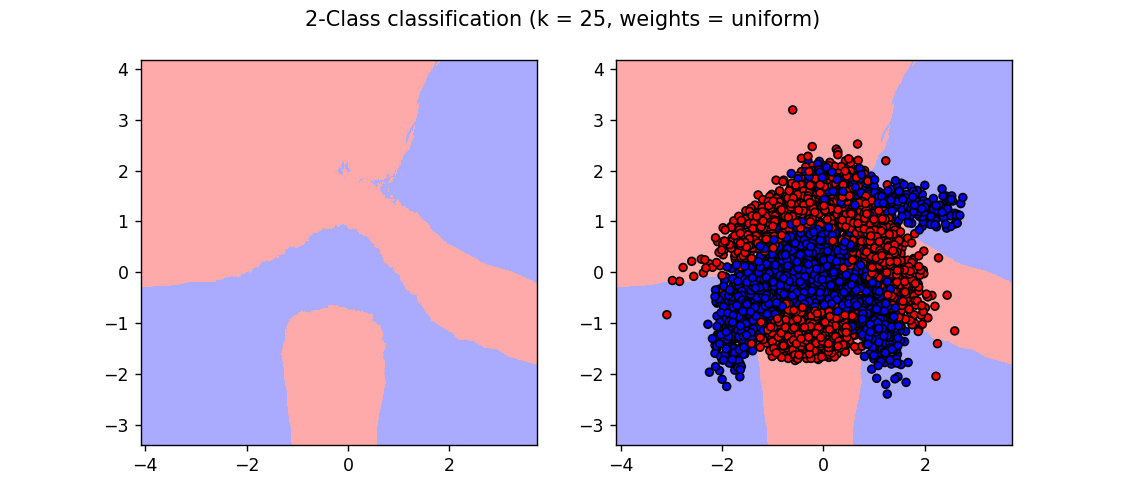

In [112]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02
clf = results[2]['knn'][0][1]
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


x_min, x_max = xTrain[:, 0].min() - 1, xTrain[:, 0].max() + 1
y_min, y_max = xTrain[:, 1].min() - 1, xTrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
ax1.pcolormesh(xx, yy, Z, cmap=cmap_light)
ax2.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
ax2.scatter(xTrain[:, 0], xTrain[:, 1], c=yTrain, cmap=cmap_bold,
            edgecolor='k', s=20)
ax1.set_xlim(xx.min(), xx.max())
ax1.set_ylim(yy.min(), yy.max())
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(yy.min(), yy.max())
f.suptitle("2-Class classification (k = 25, weights = uniform)")
plt.show()

### Plot kNN with inverse weights

<IPython.core.display.Javascript object>


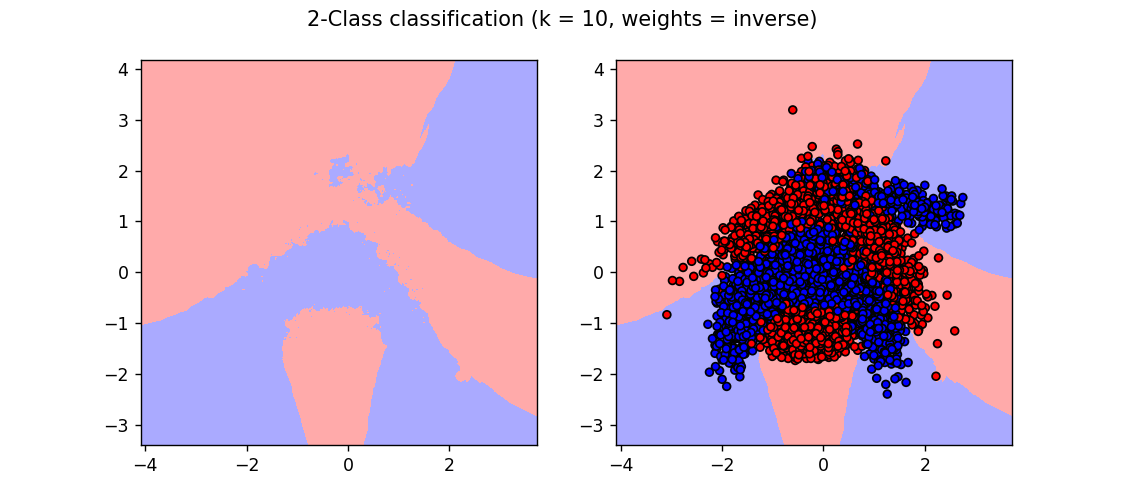

In [110]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02
clf = results[10]['dknn'][0][0]
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


x_min, x_max = xTrain[:, 0].min() - 1, xTrain[:, 0].max() + 1
y_min, y_max = xTrain[:, 1].min() - 1, xTrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
ax1.pcolormesh(xx, yy, Z, cmap=cmap_light)
ax2.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
ax2.scatter(xTrain[:, 0], xTrain[:, 1], c=yTrain, cmap=cmap_bold,
            edgecolor='k', s=20)
ax1.set_xlim(xx.min(), xx.max())
ax1.set_ylim(yy.min(), yy.max())
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(yy.min(), yy.max())
f.suptitle("2-Class classification (k = 10, weights = inverse)")
plt.show()